### Building ML Data Pipeline with Tensorflow Extended


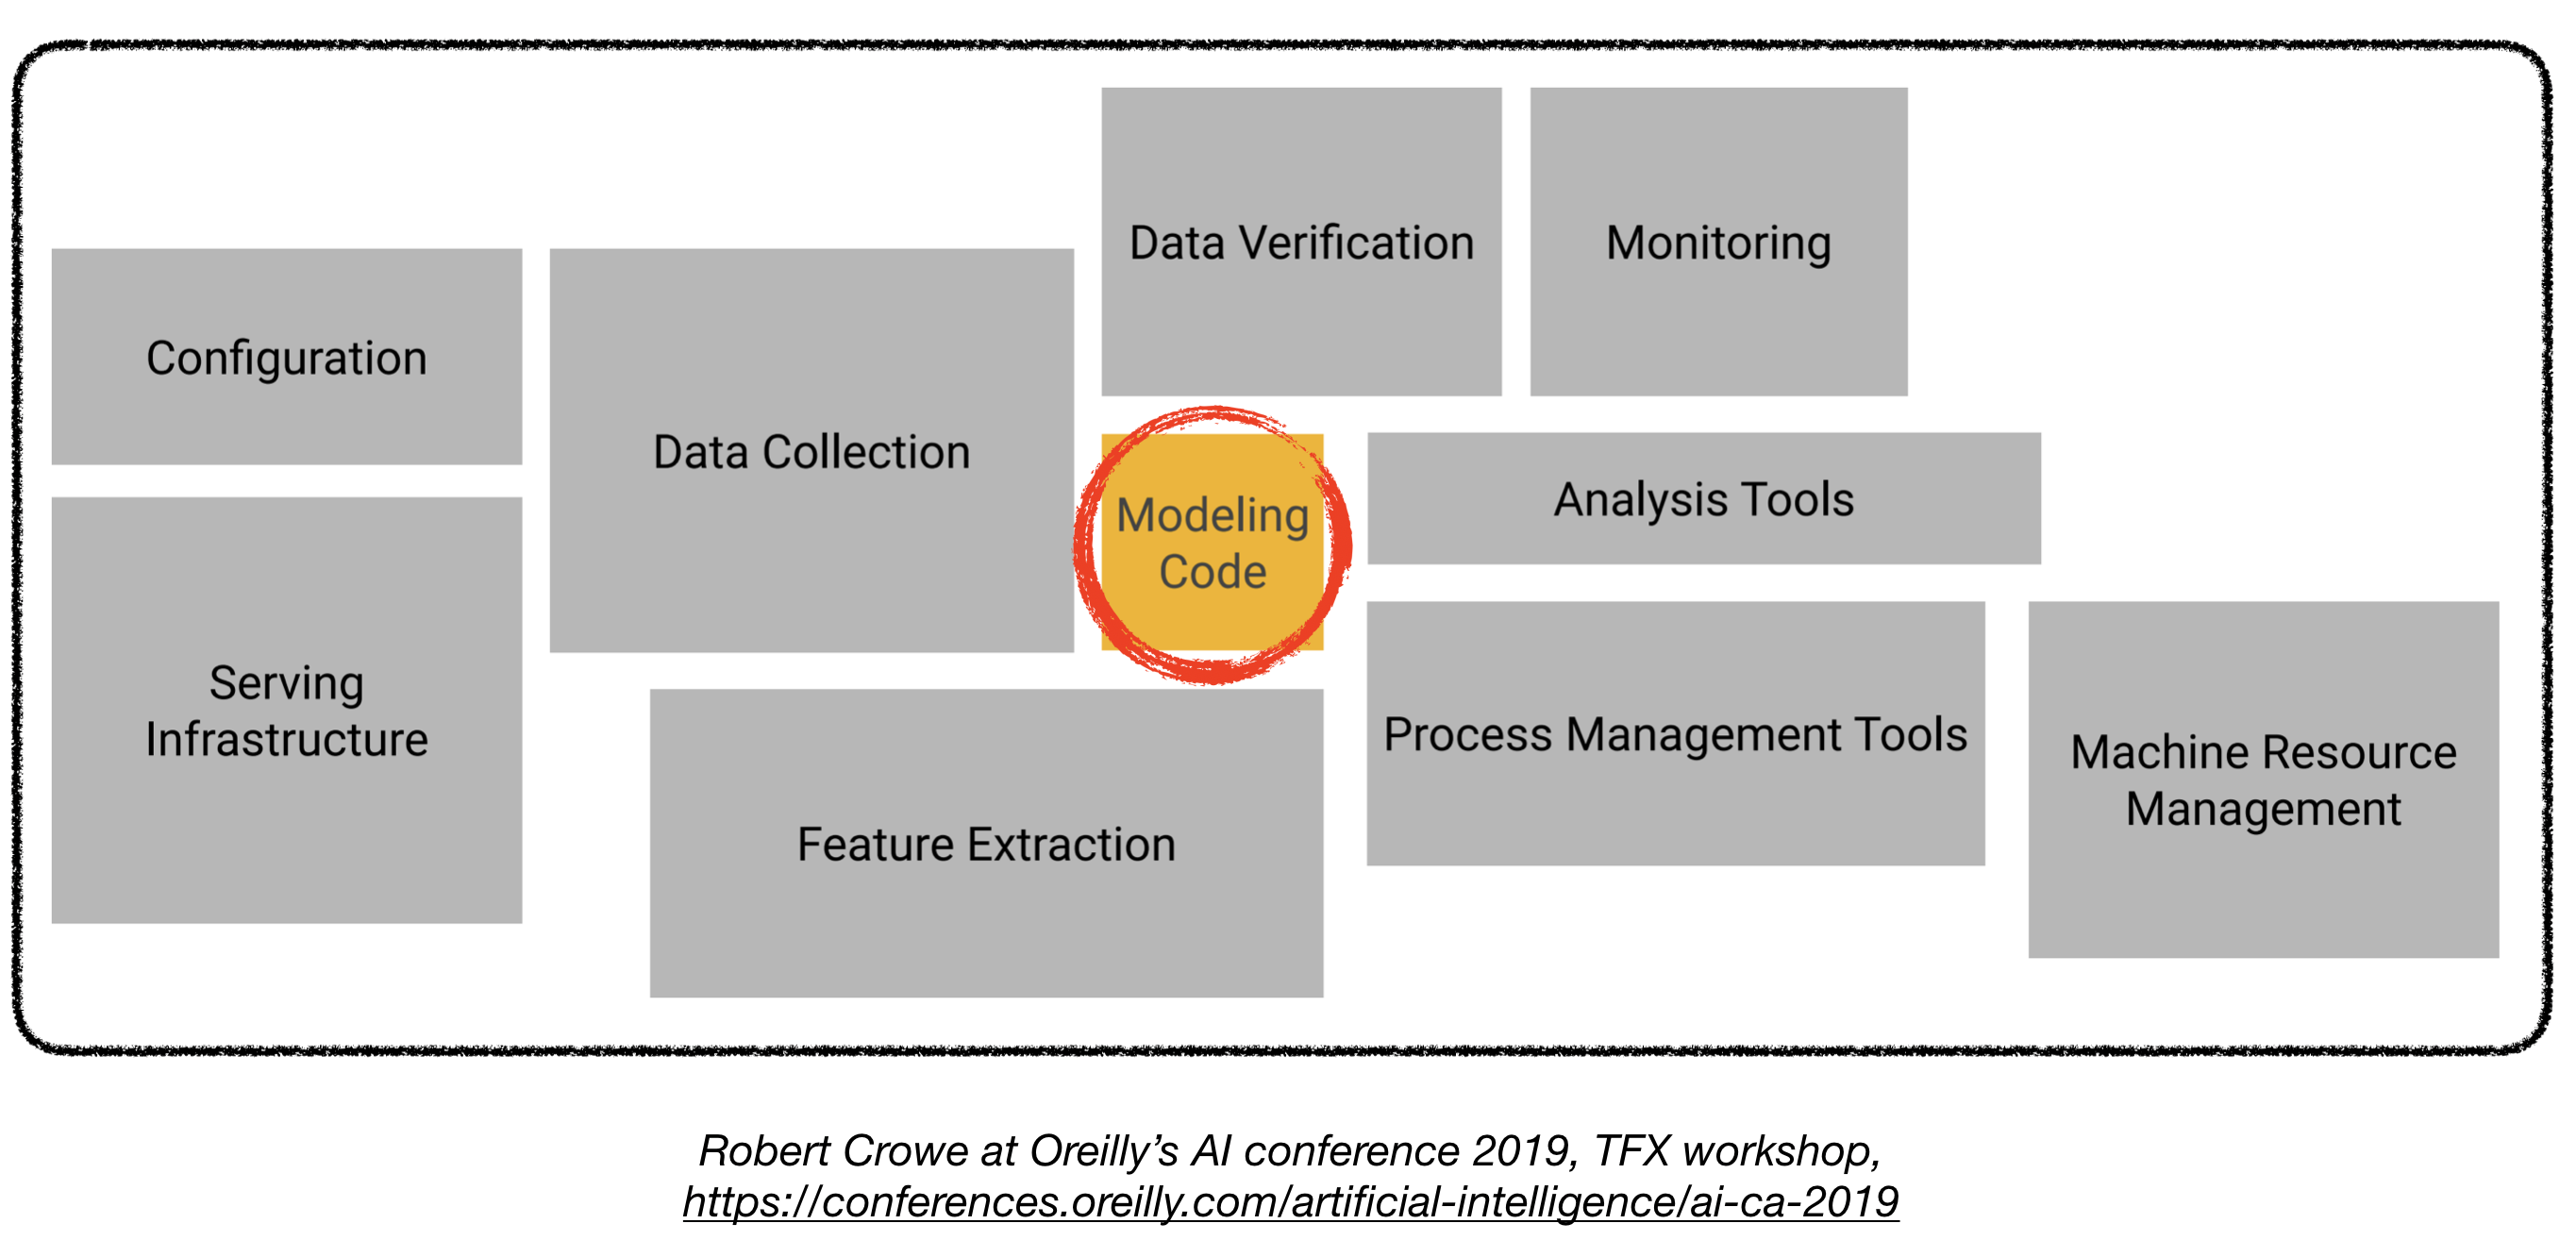

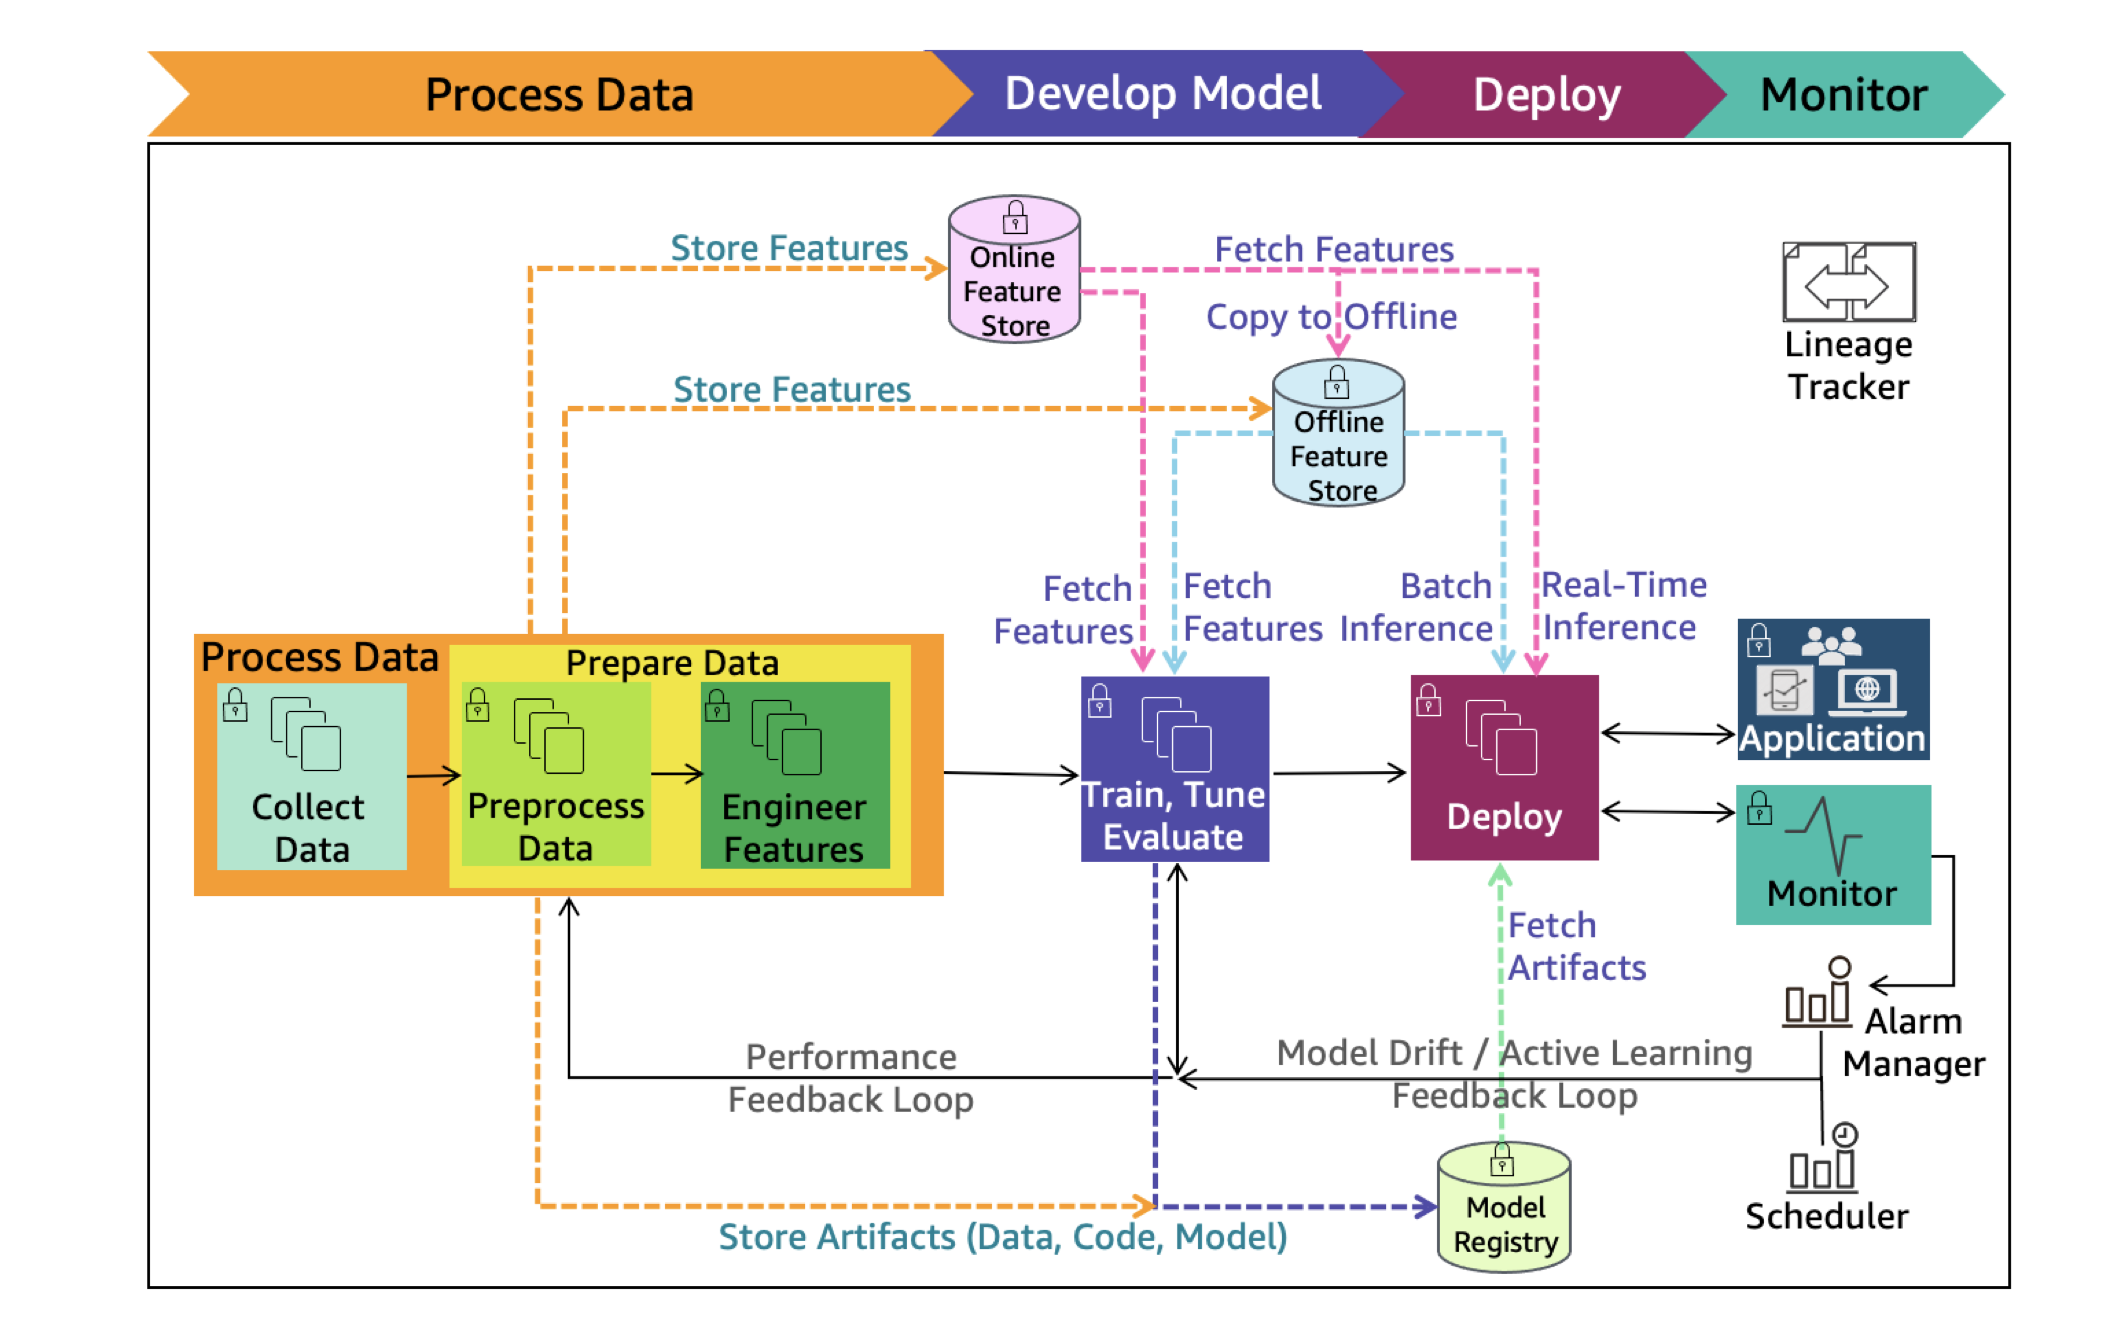

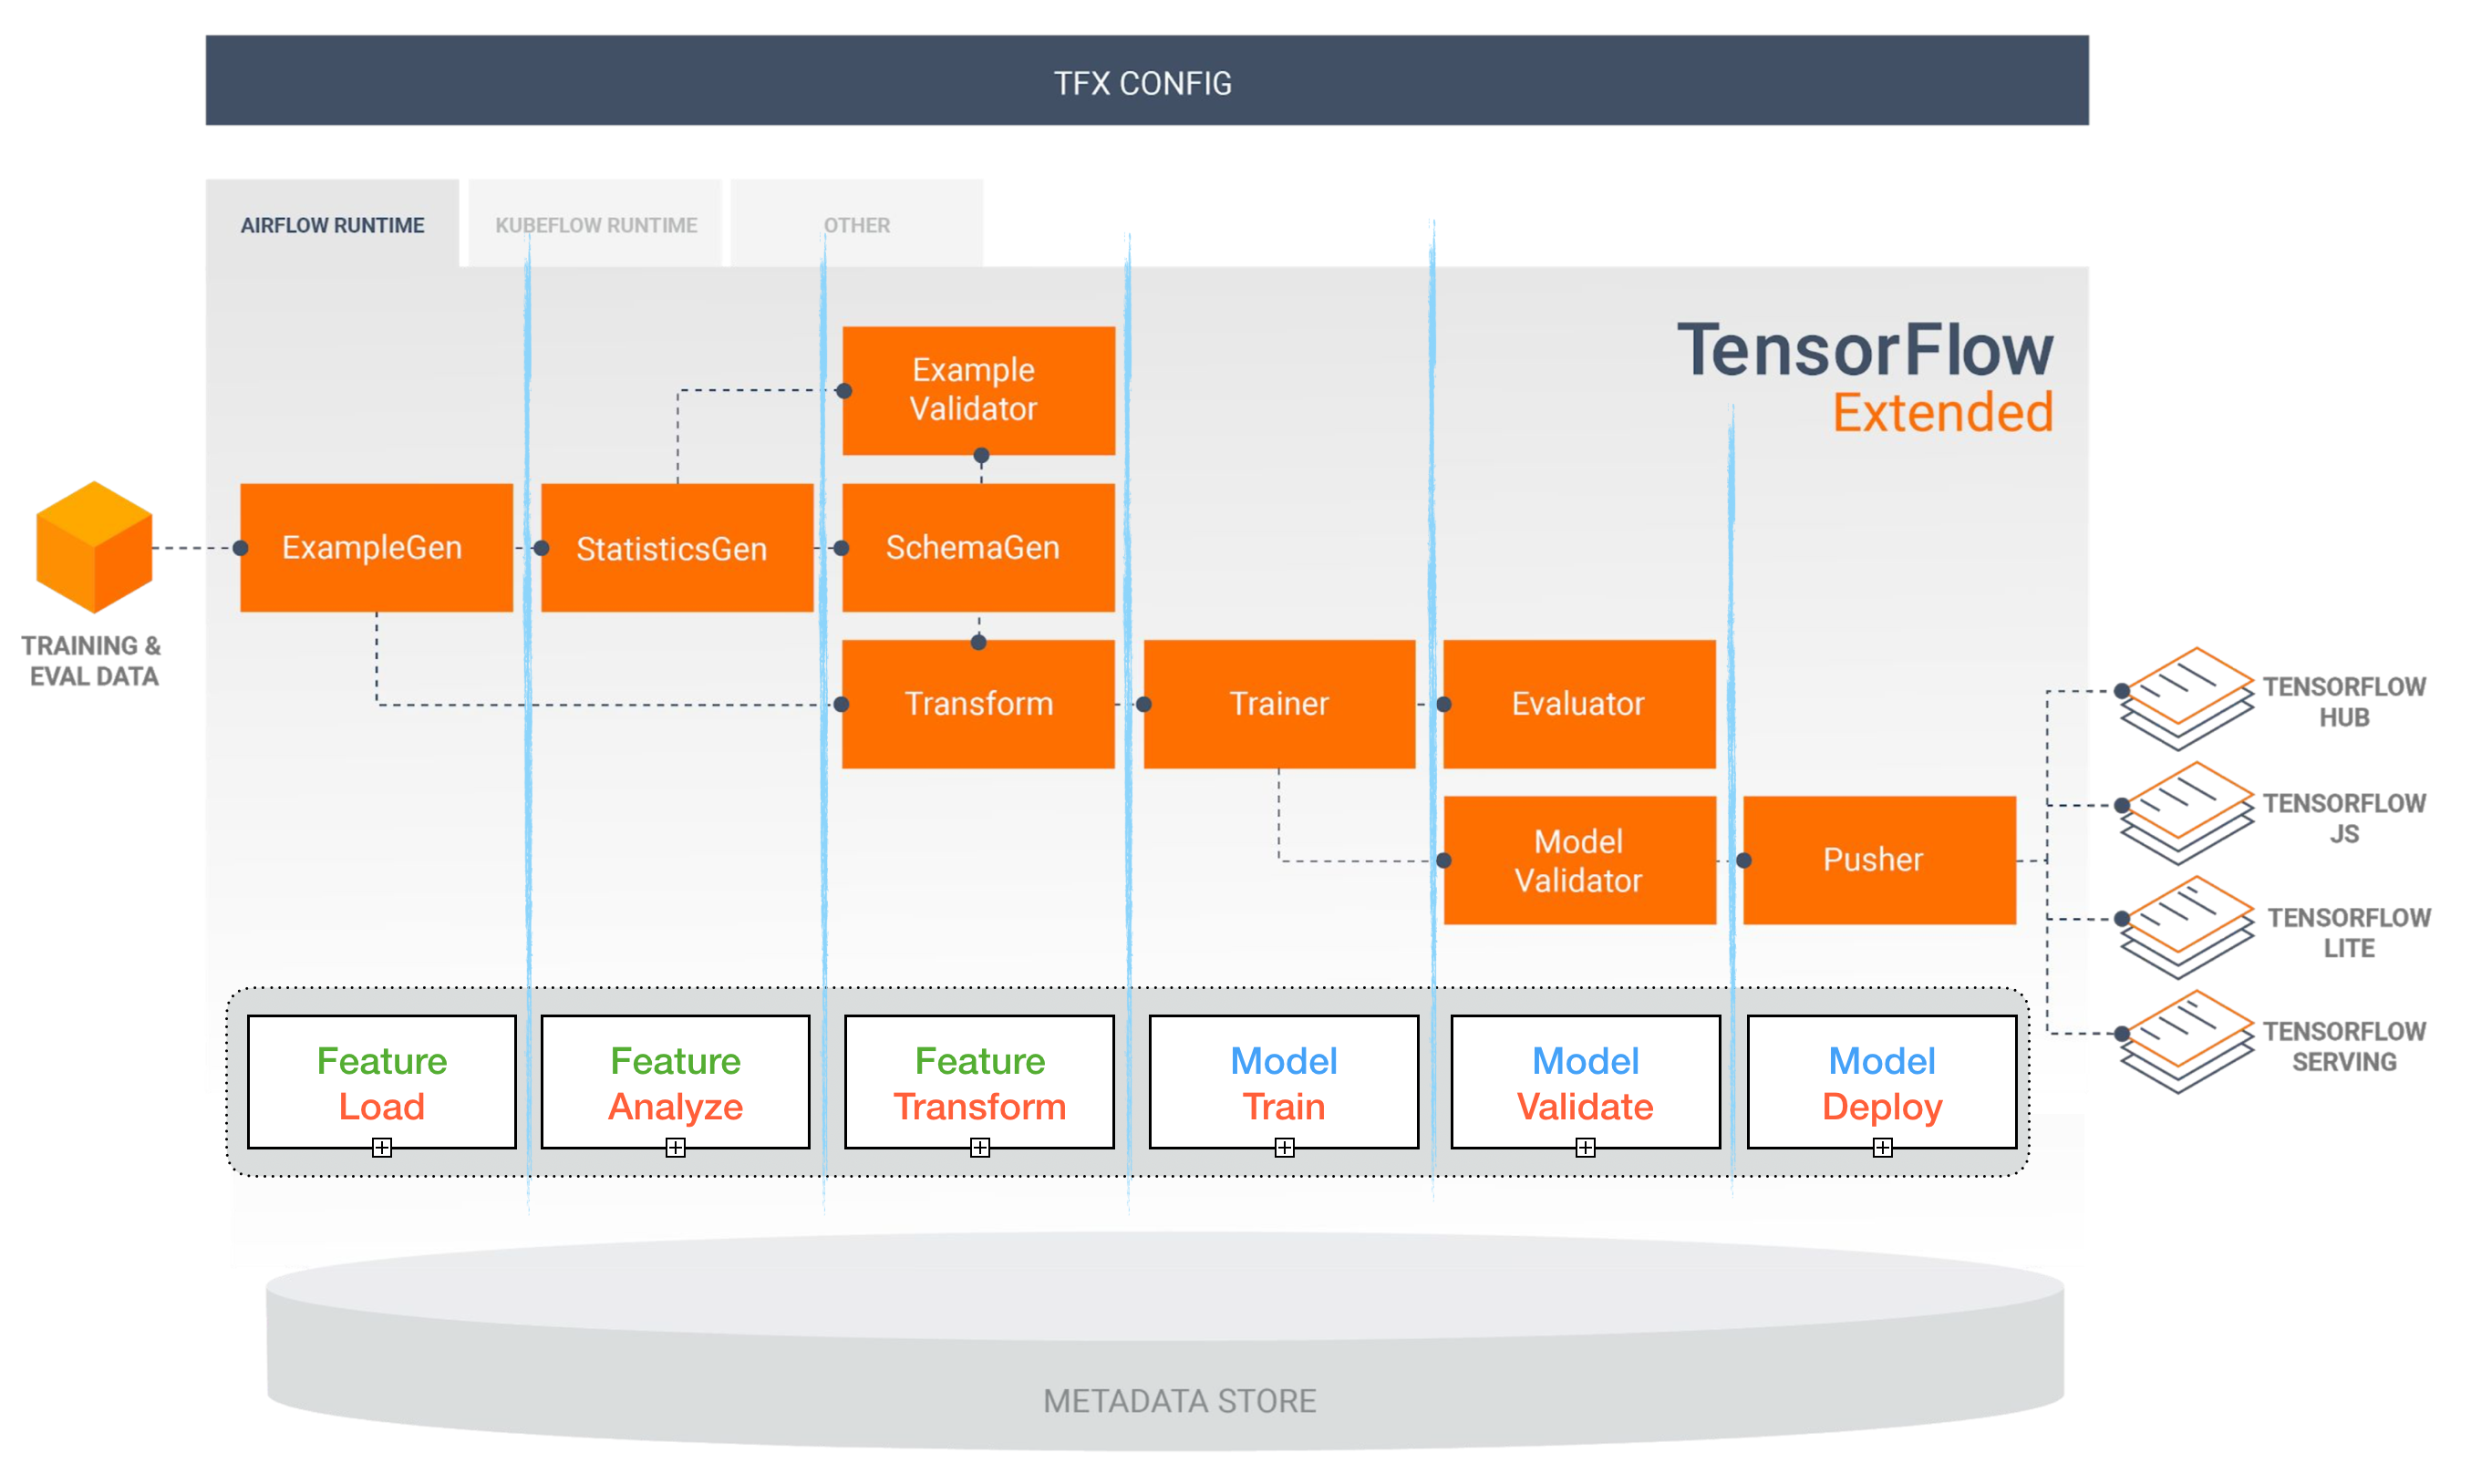

(Ctrl + Shift + P) and type "Use fallback runtime version" and select it to use Python 3.9.16 version runtime. This is allow you to run TFX examples on fallback runtime.

In [ ]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

In [ ]:
!pip install -U pip
!pip install tfx==1.12.0

In [ ]:
%%shell
sudo apt update
sudo apt install python3.8 python3.8-distutils python3.8-dev
update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 3
curl -O https://bootstrap.pypa.io/get-pip.py
python get-pip.py

In [ ]:
!grep -v google-auth /etc/requirements.core.in > requirements.txt
!grep httplib2 /etc/requirements.user.in >> requirements.txt

In [ ]:
!mkdir /usr/local/lib/python3.8/dist-packages/google
!ln -s /usr/local/lib/python3.10/dist-packages/google/colab /usr/local/lib/python3.8/dist-packages/google/colab

In [ ]:
!pip install tfx==1.13.0 -r requirements.txt

In [ ]:
!pip install -U scikit-learn

Restart the runtime

In [ ]:
import tensorflow as tf
from tfx import v1 as tfx

# TFX libraries
import tensorflow_data_validation as tfdv
import tensorflow_transform as tft
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

# For performing feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# For feature visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tensorflow.python.lib.io import file_io
from tensorflow_metadata.proto.v0 import schema_pb2
from google.protobuf.json_format import MessageToDict
from  tfx.proto import example_gen_pb2
from tfx.types import standard_artifacts
from tensorflow_transform.tf_metadata import dataset_metadata, schema_utils
import tensorflow_transform.beam as tft_beam
import os
import pprint
import tempfile
import pandas as pd

# To ignore warnings from TF
tf.get_logger().setLevel('ERROR')

# For formatting print statements
pp = pprint.PrettyPrinter()

# Display versions of TF and TFX related packages
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('TensorFlow Data Validation version: {}'.format(tfdv.__version__))
print('TensorFlow Transform version: {}'.format(tft.__version__))

TensorFlow version: 2.12.1
TFX version: 1.13.0
TensorFlow Data Validation version: 1.13.0
TensorFlow Transform version: 1.13.0


In [ ]:
# location of the pipeline metadata store
_pipeline_root = '/content/drive/MyDrive/pipeline'


# directory of the raw data files
_data_root = '/content/drive/MyDrive/dataset_diabetes'

# path to the raw training data
_data_filepath = os.path.join(_data_root, 'diabetic_data.csv')


# View file contents

In [ ]:
!head {_data_filepath}


encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,

In [ ]:
context = InteractiveContext(pipeline_root=_pipeline_root)

# Data Ingestion

We create a training and evaluation splits from our input data.

In [ ]:
from tfx.components import CsvExampleGen
# Instantiate ExampleGen with the input CSV dataset

output = tfx.proto.Output(
             split_config=example_gen_pb2.SplitConfig(splits=[
                 tfx.proto.SplitConfig.Split(name='train', hash_buckets=3),
                 tfx.proto.SplitConfig.Split(name='eval', hash_buckets=1)
             ]))

example_gen = CsvExampleGen(input_base=_data_root,output_config=output)

context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 62
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
try:
    # get the artifact object
    artifact = example_gen.outputs['examples'].get()[0]

    # print split names and uri
    print(f'split names: {artifact.split_names}')
    print(f'artifact uri: {artifact.uri}')

except IndexError:
    print("context.run() was no-op")
    examples_path = './pipeline/CsvExampleGen/examples'
    dir_id = os.listdir(examples_path)[0]
    artifact_uri = f'{examples_path}/{dir_id}'

else:
    artifact_uri = artifact.uri

split names: ["train", "eval"]
artifact uri: /content/drive/MyDrive/pipeline/CsvExampleGen/examples/62


In [ ]:
train_uri = os.path.join(artifact_uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [ ]:
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''

    # initialize an empty list
    records = []
    for tfrecord in dataset.take(num_records):

        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()

        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()

        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)

        # convert the protocol bufffer message to a Python dictionary
        example_dict = MessageToDict(example)

        # append to the records list
        records.append(example_dict)
    return records

# View sample record

In [ ]:
sample_records = get_records(dataset, 1)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'A1Cresult': {'bytesList': {'value': ['Tm9uZQ==']}},
                           'acarbose': {'bytesList': {'value': ['Tm8=']}},
                           'acetohexamide': {'bytesList': {'value': ['Tm8=']}},
                           'admission_source_id': {'int64List': {'value': ['1']}},
                           'admission_type_id': {'int64List': {'value': ['6']}},
                           'age': {'bytesList': {'value': ['WzAtMTAp']}},
                           'change': {'bytesList': {'value': ['Tm8=']}},
                           'chlorpropamide': {'bytesList': {'value': ['Tm8=']}},
                           'citoglipton': {'bytesList': {'value': ['Tm8=']}},
                           'diabetesMed': {'bytesList': {'value': ['Tm8=']}},
                           'diag_1': {'bytesList': {'value': ['MjUwLjgz']}},
                           'diag_2': {'bytesList': {'value': ['Pw==']}},
                           'diag_3': {'bytesList': {'value': ['Pw==

# Generate feature statistics

In [ ]:
from tfx.components import StatisticsGen

# Instantiate StatisticsGen with the ExampleGen ingested dataset
eval_stats = StatisticsGen(examples=example_gen.outputs['examples'],exclude_splits=['train'])

train_stats = StatisticsGen(examples=example_gen.outputs['examples'],exclude_splits=['eval'])

# Run the component
context.run(train_stats)
context.run(eval_stats)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 64
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
context.show(eval_stats.outputs['statistics'])

In [ ]:
context.show(train_stats.outputs['statistics'])

# Get feature schema

Get schema from stats component

In [ ]:
from tfx.components import SchemaGen

train_schema = SchemaGen(train_stats.outputs['statistics'])

eval_schema = SchemaGen(eval_stats.outputs['statistics'])

In [ ]:
context.run(train_schema)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 65
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
context.run(eval_schema)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 66
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
context.show(train_schema.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'A1Cresult',STRING,required,,'A1Cresult'
'acarbose',STRING,required,,'acarbose'
'acetohexamide',STRING,required,,'acetohexamide'
'admission_source_id',INT,required,,-
'admission_type_id',INT,required,,-
'age',STRING,required,,'age'
'change',STRING,required,,'change'
'chlorpropamide',STRING,required,,'chlorpropamide'
'citoglipton',STRING,required,,'citoglipton'


,Values
Domain,
'A1Cresult',"'>7', '>8', 'None', 'Norm'"
'acarbose',"'Down', 'No', 'Steady', 'Up'"
'acetohexamide',"'No', 'Steady'"
'age',"'[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'"
'change',"'Ch', 'No'"
'chlorpropamide',"'Down', 'No', 'Steady', 'Up'"
'citoglipton','No'
'diabetesMed',"'No', 'Yes'"
'examide','No'


In [ ]:
context.show(eval_schema.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'A1Cresult',STRING,required,,'A1Cresult'
'acarbose',STRING,required,,'acarbose'
'acetohexamide',STRING,required,,'acetohexamide'
'admission_source_id',INT,required,,-
'admission_type_id',INT,required,,-
'age',STRING,required,,'age'
'change',STRING,required,,'change'
'chlorpropamide',STRING,required,,'chlorpropamide'
'citoglipton',STRING,required,,'citoglipton'


,Values
Domain,
'A1Cresult',"'>7', '>8', 'None', 'Norm'"
'acarbose',"'No', 'Steady', 'Up'"
'acetohexamide','No'
'age',"'[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'"
'change',"'Ch', 'No'"
'chlorpropamide',"'No', 'Steady', 'Up'"
'citoglipton','No'
'diabetesMed',"'No', 'Yes'"
'examide','No'


# Validate Data

Perform data validation against data statistics

In [ ]:
from tfx.components import ExampleValidator
example_validator = ExampleValidator(statistics=eval_stats.outputs['statistics'],schema=train_schema.outputs['schema'])

In [ ]:
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 67
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

# Show anomalies in data

In [ ]:
context.show(example_validator.outputs['anomalies'])

,Anomaly short description,Anomaly long description
Feature name,,
'medical_specialty',Unexpected string values,"Examples contain values missing from the schema: Neurophysiology (<1%), Pediatrics-InfectiousDiseases (<1%), Surgery-PlasticwithinHeadandNeck (<1%)."
'tolazamide',Unexpected string values,Examples contain values missing from the schema: Up (<1%).


# Remove anomalies

In [ ]:
import tensorflow_data_validation as tfdv

schema_dir = '/content/drive/MyDrive/pipeline/SchemaGen/schema/23'
schema_file = schema_file = os.path.join(schema_dir, 'schema.pbtxt')

fixed_eval_schema = tfdv.load_schema_text(schema_file)

tolazamide_domain =  tfdv.get_domain(fixed_eval_schema, 'tolazamide')
tolazamide_domain.value.append('Up')

medical_specialty_domain =  tfdv.get_domain(fixed_eval_schema, 'medical_specialty')
medical_specialty_domain.value.append('Neurophysiology')
medical_specialty_domain.value.append('Pediatrics-InfectiousDiseases')
medical_specialty_domain.value.append('Surgery-PlasticwithinHeadandNeck')


In [ ]:
fixed_schema_dir = '/content/drive/MyDrive/pipeline/SchemaGen/schema/fixed'
os.mkdir(fixed_schema_dir)
schema_file = schema_file = os.path.join(fixed_schema_dir, 'schema.pbtxt')

tfdv.write_schema_text(fixed_eval_schema, schema_file)

!cat {schema_file}

feature {
  name: "A1Cresult"
  type: BYTES
  domain: "A1Cresult"
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "acarbose"
  type: BYTES
  domain: "acarbose"
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "acetohexamide"
  type: BYTES
  domain: "acetohexamide"
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "admission_source_id"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "admission_type_id"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "age"
  type: BYTES
  domain: "age"
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "change"
 

In [ ]:
schema_importer = tfx.dsl.Importer(
    source_uri=fixed_schema_dir,
    artifact_type=tfx.types.standard_artifacts.Schema
)


In [ ]:
context.run(schema_importer)

ExecutionResult(
    component_id: Importer
    execution_id: 68
    outputs:
        result: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 15
        type_id: 18
        uri: "/content/drive/MyDrive/pipeline/SchemaGen/schema/fixed"
        custom_properties {
          key: "is_external"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.12.0"
          }
        }
        type: "Schema"
        create_time_since_epoch: 1684583493535
        last_update_time_since_epoch: 1684583524685
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
            _input_trigger: None
        ))

In [ ]:
context.show(schema_importer.outputs['result'])

,Type,Presence,Valency,Domain
Feature name,,,,
'A1Cresult',STRING,required,,'A1Cresult'
'acarbose',STRING,required,,'acarbose'
'acetohexamide',STRING,required,,'acetohexamide'
'admission_source_id',INT,required,,-
'admission_type_id',INT,required,,-
'age',STRING,required,,'age'
'change',STRING,required,,'change'
'chlorpropamide',STRING,required,,'chlorpropamide'
'citoglipton',STRING,required,,'citoglipton'


,Values
Domain,
'A1Cresult',"'>7', '>8', 'None', 'Norm'"
'acarbose',"'Down', 'No', 'Steady', 'Up'"
'acetohexamide',"'No', 'Steady'"
'age',"'[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'"
'change',"'Ch', 'No'"
'chlorpropamide',"'Down', 'No', 'Steady', 'Up'"
'citoglipton','No'
'diabetesMed',"'No', 'Yes'"
'examide','No'


In [ ]:
example_validator = ExampleValidator(statistics=eval_stats.outputs['statistics'],schema=schema_importer.outputs['result'])

In [ ]:
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 69
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
context.show(example_validator.outputs['anomalies'])

# Perform Transformations on data

In [ ]:
_diabetes_constants_module_file = 'diabetes_constants.py'

In [ ]:
%%writefile {_diabetes_constants_module_file}

VOCAB_SIZE = 1000

# Feature to scale from 0 to 1
RANGE_FEATURE_KEYS = ['num_medications','num_procedures','number_diagnoses','number_emergency']

# Features with string data types that will be converted to indices
VOCAB_FEATURE_KEYS = [
    'medical_specialty'
]

# Features with int data type that will be kept as is
CATEGORICAL_FEATURE_KEYS = ['payer_code']

# Feature to predict
VOLUME_KEY = 'readmitted'

def transformed_name(key):
    return key + '_xf'

Writing diabetes_constants.py


In [ ]:
_diabetes_transform_module_file = 'diabetes_transform.py'

In [ ]:
%%writefile {_diabetes_transform_module_file}
import diabetes_constants
import tensorflow as tf
import tensorflow_transform as tft

# Unpack the contents of the constants module
_RANGE_FEATURE_KEYS = diabetes_constants.RANGE_FEATURE_KEYS
_VOCAB_FEATURE_KEYS = diabetes_constants.VOCAB_FEATURE_KEYS
_VOCAB_SIZE = 1000
_transformed_name = diabetes_constants.transformed_name


def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
    inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
    Map from string feature key to transformed feature operations.
    """
    outputs = {}


    # Scale these feature/s from 0 to 1
    for key in _RANGE_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.scale_to_0_1(inputs[key])


    # Transform the strings into indices
    # hint: use the VOCAB_SIZE and OOV_SIZE to define the top_k and num_oov parameters
    for key in _VOCAB_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(inputs[key],top_k=_VOCAB_SIZE,num_oov_buckets=10)


    ### END CODE HERE
    return outputs


Writing diabetes_transform.py


In [ ]:
from tfx.components import Transform
transform = Transform(examples=example_gen.outputs['examples'],
                      schema=schema_importer.outputs['result'],
                      module_file=os.path.abspath(_diabetes_transform_module_file))

context.run(transform, enable_cache=False)


ExecutionResult(
    component_id: Transform
    execution_id: 70
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [ ]:
context.show(transform.outputs['post_transform_schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'medical_specialty_xf',INT,required,,-
'num_medications_xf',FLOAT,required,,-
'num_procedures_xf',FLOAT,required,,-
'number_diagnoses_xf',FLOAT,required,,-
'number_emergency_xf',FLOAT,required,,-
